In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

In [2]:
import cudf
# Load the cudf.pandas extension for pandas-like GPU acceleration
%load_ext cudf.pandas

In [3]:
import pandas as pd
from glob import glob
from numba import cuda

# Directory containing the Parquet files
data_path = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"

# Collect all Parquet file paths
parquet_files = glob(f"{data_path}/partition_id=2/part-0.parquet")[-1:]

# Get the number of GPUs available
available_gpus = cuda.gpus
num_gpus = len(available_gpus)

if num_gpus == 0:
    raise RuntimeError("No GPUs available for processing.")

print(f"Number of GPUs available: {num_gpus}")

# Split files evenly across available GPUs
files_per_gpu = len(parquet_files) // num_gpus
gpu_file_splits = [
    parquet_files[i * files_per_gpu : (i + 1) * files_per_gpu]
    for i in range(num_gpus)
]

# Adjust the last split to include any remaining files
if len(parquet_files) % num_gpus != 0:
    gpu_file_splits[-1].extend(parquet_files[num_gpus * files_per_gpu :])

# Function to process files on a specific GPU
def process_files_on_gpu(files, gpu_id):
    # Select the GPU for processing
    cuda.select_device(gpu_id)
    gpu_batches = []
    for file in files:
        print(f"Processing file on GPU {gpu_id}: {file}")
        
        # Read the file into GPU memory using pandas
        gpu_df = pd.read_parquet(file)
        
        # Keep all columns, no filtering
        gpu_batches.append(gpu_df)
        
        print(f"File {file} processed on GPU {gpu_id}.")

    # Concatenate all batches for this GPU into a single DataFrame
    if gpu_batches:
        return pd.concat(gpu_batches, ignore_index=True)
    else:
        return pd.DataFrame()

# Process files on all available GPUs
final_gpu_dfs = []
for gpu_id, files in enumerate(gpu_file_splits):
    gpu_df = process_files_on_gpu(files, gpu_id)
    final_gpu_dfs.append(gpu_df)

# Combine all processed batches across GPUs into a single DataFrame
final_df = pd.concat(final_gpu_dfs, ignore_index=True)

# Print summary
print(f"Final DataFrame shape on GPU: {final_df.shape}")

Number of GPUs available: 2
Processing file on GPU 1: /kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
File /kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet processed on GPU 1.
Final DataFrame shape on GPU: (3036873, 93)


In [4]:
final_df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id
0,340,0,0,1.902722,-0.523490,-0.131996,0.124154,-0.185518,2.011005,-0.665424,...,0.251685,0.421458,0.771927,0.071990,1.426416,0.814566,-0.132949,1.183992,0.371725,2
1,340,0,1,4.090041,-0.156282,0.289095,0.193019,-0.070085,1.140459,-0.528798,...,-0.199408,-0.148638,-0.796567,-0.929294,0.055380,-0.585740,-0.891481,0.184394,-0.402399,2
2,340,0,2,1.403712,-0.002521,-0.261839,-0.006259,0.041238,1.180197,-1.034970,...,0.268406,-0.458026,-1.878922,4.185539,0.808422,0.217188,4.563775,0.802501,1.707263,2
3,340,0,3,0.904068,0.285563,0.159232,0.158522,-0.564407,1.300828,-0.625577,...,0.960588,0.610246,2.921769,-0.170994,1.217213,1.891398,-1.207013,0.868314,0.723984,2
4,340,0,7,1.308947,0.321869,0.211620,-0.195385,-0.358547,1.595914,-0.820045,...,2.084096,0.359311,0.511679,-0.377202,0.441480,-0.564688,-2.682818,0.118382,-1.588810,2


In [5]:
final_df.describe()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
count,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,...,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06,3.036873e+06
mean,4.291543e+02,4.240000e+02,1.521666e+01,1.717335e+00,8.268140e-01,3.165000e-03,8.313690e-01,8.294900e-01,-2.020900e-02,1.914100e-02,...,-1.082300e-02,5.380000e-04,4.950000e-03,6.300000e-05,-8.826000e-03,-1.469000e-02,-4.485000e-03,-8.083000e-03,-1.249600e-02,-3.620000e-03
std,5.049334e+01,2.450851e+02,1.099118e+01,1.031991e+00,9.515400e-01,9.875580e-01,9.521130e-01,9.522110e-01,9.909670e-01,1.031741e+00,...,9.518430e-01,7.601480e-01,7.708780e-01,7.918200e-01,8.109900e-01,9.231820e-01,7.056430e-01,9.401580e-01,9.732750e-01,9.159290e-01
min,3.400000e+02,0.000000e+00,0.000000e+00,2.828080e-01,-2.506287e+00,-5.741592e+00,-2.384608e+00,-2.405387e+00,-4.047346e+00,-9.611462e+00,...,-4.035309e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00
25%,3.850000e+02,2.120000e+02,8.000000e+00,9.706670e-01,9.603400e-02,-6.746040e-01,1.036410e-01,1.007840e-01,-7.039520e-01,-4.842460e-01,...,-3.111540e-01,-2.494910e-01,-2.144570e-01,-2.412090e-01,-3.556910e-01,-4.347860e-01,-2.504160e-01,-4.277740e-01,-4.665820e-01,-3.641880e-01
50%,4.310000e+02,4.240000e+02,1.300000e+01,1.462468e+00,9.134960e-01,-1.964800e-02,9.154990e-01,9.138320e-01,-2.398000e-02,-1.855300e-02,...,-2.116180e-01,-5.889000e-03,-2.482100e-02,-1.070000e-03,-2.131700e-02,-3.685800e-02,-7.649000e-03,-2.127000e-02,-3.044400e-02,-6.425000e-03
75%,4.750000e+02,6.360000e+02,1.900000e+01,2.112812e+00,1.552006e+00,6.533740e-01,1.553802e+00,1.552609e+00,6.601070e-01,4.567960e-01,...,9.584000e-03,2.393740e-01,1.811680e-01,2.392230e-01,3.163610e-01,3.701440e-01,2.335790e-01,3.848970e-01,4.021160e-01,3.480330e-01
max,5.090000e+02,8.480000e+02,3.800000e+01,7.189140e+00,4.194370e+00,4.326710e+00,4.180225e+00,4.145898e+00,4.115090e+00,1.899487e+01,...,1.332677e+02,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


Using ffill to fill missing values for time series data

In [6]:
df = final_df.fillna(method="ffill")

/opt/conda/lib/python3.10/site-packages/cudf/core/frame.py:732: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  warnings.warn(


Preparing lagged responder values. For a given date_id and time_id, the lagged value corresponds to the same time_id but (date_id-1).

**Example:**

Current Entry (date_id = 2, time_id = 4)

Lagged Values (date_id = 1, time_id = 4)


In [7]:
# List of responder columns
responder_columns = [f"responder_{i}" for i in range(9)]

# Apply the lagging for each responder column
for responder in responder_columns:
    lagged_column_name = f"{responder}_lag"
    final_df[lagged_column_name] = final_df.groupby(["time_id", "symbol_id"])[responder].shift(1)

# Display the first few rows to verify
final_df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,partition_id,responder_0_lag,responder_1_lag,responder_2_lag,responder_3_lag,responder_4_lag,responder_5_lag,responder_6_lag,responder_7_lag,responder_8_lag
0,340,0,0,1.902722,-0.523490,-0.131996,0.124154,-0.185518,2.011005,-0.665424,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,340,0,1,4.090041,-0.156282,0.289095,0.193019,-0.070085,1.140459,-0.528798,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,340,0,2,1.403712,-0.002521,-0.261839,-0.006259,0.041238,1.180197,-1.034970,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,340,0,3,0.904068,0.285563,0.159232,0.158522,-0.564407,1.300828,-0.625577,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,340,0,7,1.308947,0.321869,0.211620,-0.195385,-0.358547,1.595914,-0.820045,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Validating lags
- Plotting original responder vs lagged values

In [8]:
plot_data = final_df.groupby(["symbol_id"])

<Axes: >

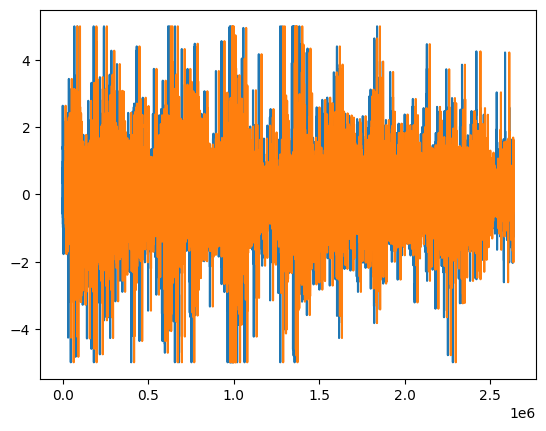

In [9]:
for c,i in plot_data:
    i.head()
    break

i["responder_6"].plot()
i["responder_6_lag"].plot()

# Training

## XGBoost Model
- Early stopping implemented to make training faster
- Current issues include test loss remaining constant while train loss decreasing
- Average R^2: 0.0096


Starting Fold 1/5
[0]	train-rmse:0.92517	eval-rmse:0.99490
[100]	train-rmse:0.88906	eval-rmse:0.98909
[200]	train-rmse:0.86567	eval-rmse:0.99043
[225]	train-rmse:0.86068	eval-rmse:0.99093
Fold 1 Mean Squared Error: 0.9820
Fold 1 R-squared: 0.0083

Starting Fold 2/5
[0]	train-rmse:0.92084	eval-rmse:1.01085
[100]	train-rmse:0.88641	eval-rmse:1.01146
[124]	train-rmse:0.88078	eval-rmse:1.01341
Fold 2 Mean Squared Error: 1.0270
Fold 2 R-squared: -0.0045

Starting Fold 3/5
[0]	train-rmse:0.94362	eval-rmse:0.92267
[100]	train-rmse:0.90540	eval-rmse:0.91723
[179]	train-rmse:0.88615	eval-rmse:0.91773
Fold 3 Mean Squared Error: 0.8422
Fold 3 R-squared: 0.0114

Starting Fold 4/5
[0]	train-rmse:0.95817	eval-rmse:0.86053
[100]	train-rmse:0.91989	eval-rmse:0.85586
[200]	train-rmse:0.89630	eval-rmse:0.85608
[241]	train-rmse:0.88682	eval-rmse:0.85639
Fold 4 Mean Squared Error: 0.7334
Fold 4 R-squared: 0.0102

Starting Fold 5/5
[0]	train-rmse:0.94873	eval-rmse:0.90187
[100]	train-rmse:0.91041	eval-rms

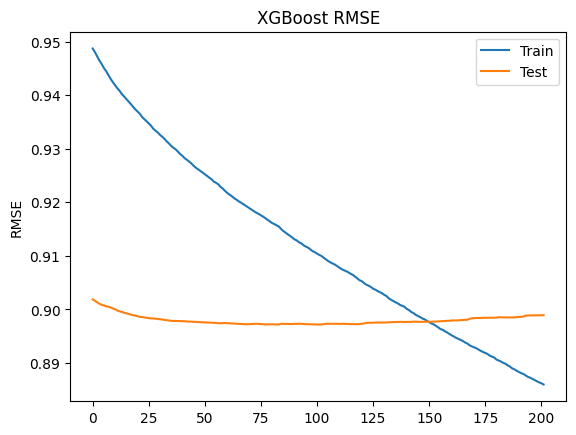

In [10]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import numpy as np

# Assume `final_df` is a pandas DataFrame
df = final_df

# Assuming `features_*` are all columns starting with "feature_" or ending with "_lag"
feature_columns = [col for col in df.columns if col.startswith('feature_') or col.endswith("lag_1")]
target_column = 'responder_6'

# Extract features and target
X = df[feature_columns]
y = df[target_column]

# Set up cross-validation
n_splits = 5  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=False)

# Initialize lists to store results
mse_scores = []
r2_scores = []

fold = 1
for train_index, test_index in kf.split(X):
    print(f"\nStarting Fold {fold}/{n_splits}")

    # Split features and target into training and validation sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Convert training and validation data to GPU-compatible DMatrix
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    dtest = xgb.DMatrix(X_test.values, label=y_test.values)

    # Set up XGBoost parameters
    params = {
        'objective': 'reg:squarederror',
        'tree_method': "hist",
        'device': "cuda",
        'eval_metric': 'rmse',
        'verbosity': 1,
        'seed': 49,
        'max_depth': 8,
        'learning_rate': 0.05,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'alpha': 0.5,    # Add L1 regularization
        'lambda': 1.0    # Add L2 regularization
    }

    # Train the model
    evals_result = {}
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=800,
        evals=[(dtrain, 'train'), (dtest, 'eval')],
        early_stopping_rounds=100,
        evals_result=evals_result,
        verbose_eval=100
    )

    # Predict on the validation set
    y_pred = bst.predict(dtest)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Fold {fold} Mean Squared Error: {mse:.4f}")
    print(f"Fold {fold} R-squared: {r2:.4f}")

    # Store the scores
    mse_scores.append(mse)
    r2_scores.append(r2)

    fold += 1

# Calculate and print the average scores
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print("\nCross-Validation Results:")
print(f"Average Mean Squared Error over {n_splits} folds: {avg_mse:.4f}")
print(f"Average R-squared over {n_splits} folds: {avg_r2:.4f}")

import matplotlib.pyplot as plt

epochs = len(evals_result['train']['rmse'])
x_axis = range(0, epochs)

# Plot RMSE
plt.figure()
plt.plot(x_axis, evals_result['train']['rmse'], label='Train')
plt.plot(x_axis, evals_result['eval']['rmse'], label='Test')
plt.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [11]:
# Train the final model on the entire dataset
dtrain_full = xgb.DMatrix(X.values, label=y.values)
final_model = xgb.train(
    params,
    dtrain_full,
    num_boost_round=bst.best_iteration
)

# Feature Importance from the final model
importances = final_model.get_score(importance_type='gain')
importances = {int(k[1:]): v for k, v in importances.items()}  # Convert feature names to indices

# Create a pandas DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': [feature_columns[i] for i in importances.keys()],
    'Importance': list(importances.values())
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))


Top 10 Important Features:
       Feature  Importance
6   feature_06  172.034683
27  feature_30   84.332489
57  feature_61   78.672287
52  feature_56   78.549652
55  feature_59   77.853737
41  feature_45   75.263000
23  feature_24   74.149292
26  feature_29   74.032875
22  feature_23   71.911659
56  feature_60   71.737671


In [12]:
final_model.save_model("xgbbost_lags_1.json")

## LightGBM